---
## Load Data

In [12]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [120]:
youth_crime = pd.read_csv('../data/state_demo_crime_youth_data_combined_clean.csv')

In [122]:
# drop other youth crime columns after creating combined youth crime target variable
print(youth_crime.shape)
youth_crime.drop(columns = ['crimes_against_society',
                            'fraud_and_other_financial_crimes',
                            'property_crime',
                            'violent_crime'],
                inplace = True)
print(youth_crime.shape)

(312, 28)
(312, 24)


In [344]:
# create numerical features list
numerical_features = list(youth_crime.drop(columns = ['state','year',
                                                      'total_pop',
                                                      'white_pop','black_pop',
                                                      'hispanic_pop','asian_pop','native_pop',
                                                      'islander_pop','multi_race_pop',                                                    
                                                      'total_youth_crime']).columns)

numerical_features

['median_income',
 'poverty_rate',
 'unemployment_rate',
 'unemployed_15_weeks',
 'labor_force_participation_rate',
 'hs_grad_rate',
 'bachelors_grad_rate',
 'zhvi',
 'crude_rate_suicide',
 'crude_rate_od',
 'youth_not_in_school',
 'youth_in_foster_care',
 'youth_living_in_poverty']

In [346]:
# create ordinal features list
ordinal_features = ['year']

ordinal_features

['year']

In [348]:
# create nominal features list
nominal_features = ['state']

nominal_features

['state']

### Establish Variable Pipelines

In [351]:
# create numerical features pipeline
num_pipe = Pipeline([
    ('si', SimpleImputer(strategy = 'median')), # imputing median values for suppressed youth suicide and OD rates
    ('ss', StandardScaler()) # scaling features
])

In [353]:
# create ordinal features pipeline
ord_pipe = Pipeline([
    ('ohe', OrdinalEncoder()) # ordinal encoding for ordinal variables
])

In [355]:
# create nominal features pipeline
nom_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first')) # one-hot encoding for nominal variables
])

In [357]:
# combine pipelines
columns_trans = ColumnTransformer([
    ('num_processor', num_pipe, numerical_features),
    ('ord_processor', ord_pipe, ordinal_features),
    ('nom_processor', nom_pipe, nominal_features)
])

### Train-Test Split

In [360]:
# create features matrix
X = youth_crime[numerical_features + ordinal_features + nominal_features]

# create target variable, log target variable
y = youth_crime['total_youth_crime']

# process X
X_process = columns_trans.fit_transform(X)

# save features
X_process_features = columns_trans.fit(X).get_feature_names_out()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_process, y,
                                                    random_state = 42,
                                                    test_size = 0.25)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (234, 64)
X_test shape: (78, 64)
y_train shape: (234,)
y_test shape: (78,)


---
## Create Models

### Create Decision Tree Model

In [364]:
# establish Logistic Regression pipeline with CountVectorizer
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor(random_state = 42,
                                 max_depth = 5,
                                 min_samples_split = 7,
                                 min_samples_leaf = 3,
                                 ccp_alpha = 0.01))
])

In [366]:
# calculate cross validation score mean
print(f'Cross Validation mean: {cross_val_score(pipe_dt, X_train, y_train, cv = 3).mean()}')

# fit model to training data
pipe_dt.fit(X_train, y_train)

# training accuracy
print(f'Training accuracy: {pipe_dt.score(X_train, y_train)}')

# test accuracy
print(f'Testing accuracy: {pipe_dt.score(X_test, y_test)}')

Cross Validation mean: 0.28043956631470635
Training accuracy: 0.8474139910917331
Testing accuracy: 0.09659794921983256


### GridSearch DecisionTree

In [369]:
grid_dt = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 42),
                    param_grid = {'max_depth': range(2,8,1),
                                  'min_samples_split': range(8,25,3),
                                  'min_samples_leaf': range(2,7),
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                                  'max_features': range(5,21,5)},
                    cv = 5,
                    verbose = 1)

In [371]:
# start timer
t0 = time.time()

# print start time
print(t0)

# gridsearch
grid_dt.fit(X_train, y_train)

# print end time
print(time.time() - t0)

1730243361.1617303
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
55.431878089904785


In [372]:
best_model_dt = grid_dt.best_estimator_

best_model_dt

DecisionTreeRegressor(ccp_alpha=0, max_depth=6, max_features=15,
                      min_samples_leaf=5, min_samples_split=8, random_state=42)

In [373]:
grid_dt.best_score_

0.4835715164481097

In [374]:
print(f'Score on training set: {grid_dt.score(X_train, y_train)}')
print(f'Score on testing set: {grid_dt.score(X_test, y_test)}')

Score on training set: 0.6864437435286687
Score on testing set: -0.10775012856045763


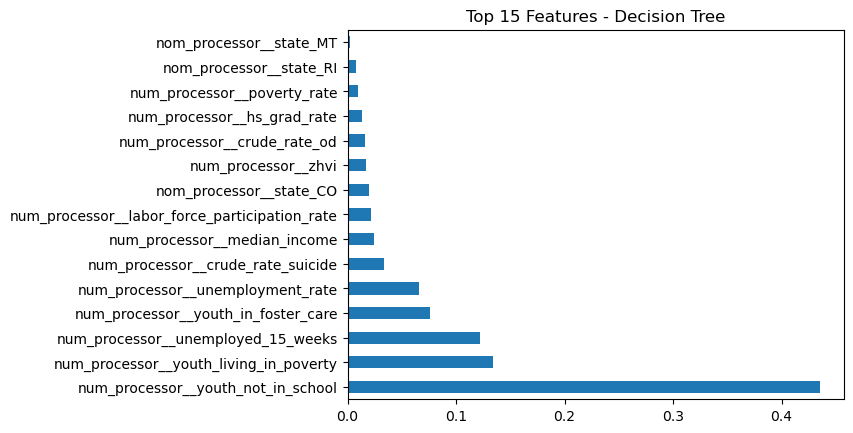

In [375]:
feat_importances = pd.Series(best_model_dt.feature_importances_, index = X_process_features)
feat_importances.nlargest(15).plot(kind = 'barh')
plt.title('Top 15 Features - Decision Tree')
plt.show()

### Create Random Forest Model

In [377]:
# establish Logistic Regression pipeline with CountVectorizer
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state = 42,
                                 max_depth = 5,
                                 min_samples_split = 7,
                                 min_samples_leaf = 3,
                                 ccp_alpha = 0.01))
])

In [378]:
# calculate cross validation score mean
print(f'Cross Validation mean: {cross_val_score(pipe_rf, X_train, y_train, cv = 3).mean()}')

# fit model to training data
pipe_rf.fit(X_train, y_train)

# training accuracy
print(f'Training accuracy: {pipe_rf.score(X_train, y_train)}')

# test accuracy
print(f'Testing accuracy: {pipe_rf.score(X_test, y_test)}')

Cross Validation mean: 0.45391550680954645
Training accuracy: 0.7863803304176995
Testing accuracy: 0.5142621546340168


### GridSearch RandomForest

In [380]:
grid_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 42, n_jobs = -1),
                    param_grid = {'max_depth': range(2,8,1),
                                  'min_samples_split': range(8,25,3),
                                  'min_samples_leaf': range(2,7),
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                                  'max_features': range(5,21,5)},
                    cv = 5,
                    verbose = 1)

In [381]:
# start timer
t0 = time.time()

# print start time
print(t0)

# gridsearch
grid_rf.fit(X_train, y_train)

# print end time
print(time.time() - t0)

1730243417.7323864
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
3234.535393714905


In [382]:
best_model_rf = grid_rf.best_estimator_

best_model_rf

RandomForestRegressor(ccp_alpha=0.01, max_depth=7, max_features=15,
                      min_samples_leaf=2, min_samples_split=8, n_jobs=-1,
                      random_state=42)

In [383]:
grid_rf.best_score_

0.5478218220597806

In [384]:
print(f'Score on training set: {grid_rf.score(X_train, y_train)}')
print(f'Score on testing set: {grid_rf.score(X_test, y_test)}')

Score on training set: 0.8006544167119154
Score on testing set: 0.5663870338466163


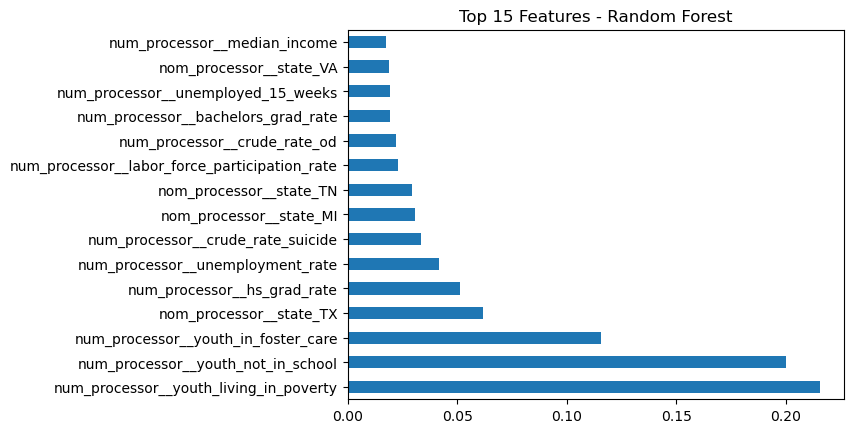

In [385]:
feat_importances = pd.Series(best_model_rf.feature_importances_, index = X_process_features)
feat_importances.nlargest(15).plot(kind = 'barh')
plt.title('Top 15 Features - Random Forest')
plt.show();